# $gg (\to h^{\ast}) \to ZZ$ sample reweighting, $c_6$-modification, and analytical density ratios

In [56]:
import numpy as np
import matplotlib.pyplot as plt

from hstar import process, trilinear

import importlib
importlib.reload(process)
importlib.reload(trilinear)

<module 'hstar.trilinear' from '/home/max/Uni/WS24/BachelorArbeit/higgs-offshell-interpretation/hstar/trilinear.py'>

## The "Baseline" sample

The baseline sample consists of events from 3 channels:
- $4\ell$,
- $4\mu$, and
- $2\ell 2\mu$,
where interference effects between the identical final state particles in the first 2 channels must be (and have been) taken into account.


$$ |\mathcal{M}|^2 =  $$

In [57]:
sample = process.Sample(weight='wt', 
    amplitude = process.Basis.SBI, components = {
    process.Basis.SBI: 'msq_sbi_sm',
    process.Basis.SIG: 'msq_sig_sm',
    process.Basis.BKG: 'msq_bkg_sm',
    process.Basis.INT: 'msq_int_sm'
  })

sample.open(csv = [
  '/u/taepa/mcfm/events/ggZZ4e_all/events.csv',
  '/u/taepa/mcfm/events/ggZZ4m_all/events.csv',
  '/u/taepa/mcfm/events/ggZZ2e2m_all/events.csv'
  ], xs=[1.4783394, 0.47412769, 0.47412769], lumi=3000., k=1.83
)

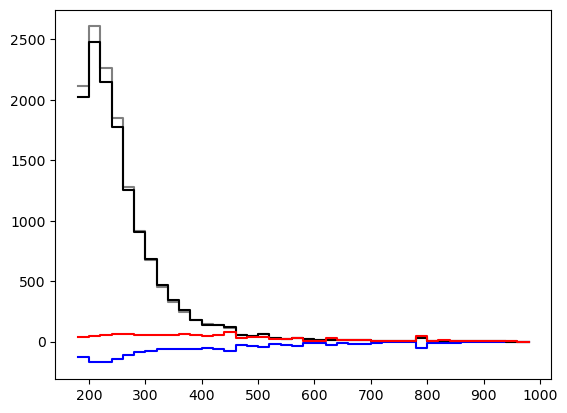

In [58]:
# compute m4l
ileptons = range(3,7)
p4l_px = np.sum([sample.events[f'p{i}_px'] for i in ileptons], axis=0)
p4l_py = np.sum([sample.events[f'p{i}_py'] for i in ileptons], axis=0)
p4l_pz = np.sum([sample.events[f'p{i}_pz'] for i in ileptons], axis=0)
p4l_E = np.sum([sample.events[f'p{i}_E'] for i in ileptons], axis=0)
m4l = np.sqrt(p4l_E**2 - p4l_px**2 - p4l_py**2 - p4l_pz**2)

# reweight to (S,B,I) amplitudes
m4l_bins = np.arange(180.0,1020.0,20.0)
# m4l_centers = 0.5 * (m4l_bins[1:] + m4l_bins[:-1])

h_m4l_sbi, _ = np.histogram(m4l, bins=m4l_bins, weights=sample.reweight(process.Basis.SBI))
h_m4l_sig, _ = np.histogram(m4l, bins=m4l_bins, weights=sample.reweight(process.Basis.SIG))
h_m4l_bkg, _ = np.histogram(m4l, bins=m4l_bins, weights=sample.reweight(process.Basis.BKG))
h_m4l_int, _ = np.histogram(m4l, bins=m4l_bins, weights=sample.reweight(process.Basis.INT))

plt.step(m4l_bins[:-1], h_m4l_sbi, where='post', color='black', label='SBI', zorder=9)
plt.step(m4l_bins[:-1], h_m4l_sig, where='post', color='red', label='SIG', zorder=10)
plt.step(m4l_bins[:-1], h_m4l_bkg, where='post', color='grey', label='BKG', zorder=7)
plt.step(m4l_bins[:-1], h_m4l_int, where='post', color='blue', label='INT', zorder=8)

## $c_6$ morphing

The SM amplitudes can be obtained by the reweightin procedure above.

The order of polynomial dependence of each amplitude component is as follows:
- $$f_{\mathrm{sig}}(c_6) = f^{(4)}(c_6) = a + b c_6 + d c_6^2 + e c_6^3 + f c_6^4$$
- $$b$$

Since the morphing is specific to the amplitude component, a modifier class dedicated to each should be configured.
In addition, it determines how many unique $c_6$ coordinates and their correspondingly-modified amplitudes are required to fully solve the polynomial dependence.

In [59]:
c6mod_sbi = trilinear.Modifier( process.Basis.SBI, c6_values = [-5, -1, 0, 1, 5], c6_amplitudes=['msq_sbi_c6_6', 'msq_sbi_c6_10', 'msq_sbi_c6_11', 'msq_sbi_c6_12', 'msq_sbi_c6_16'])
c6mod_sig = trilinear.Modifier( process.Basis.SIG, c6_values = [-5, -1, 0, 1, 5], c6_amplitudes=['msq_sig_c6_6', 'msq_sig_c6_10', 'msq_sig_c6_11', 'msq_sig_c6_12', 'msq_sig_c6_16'])
c6mod_bkg = trilinear.Modifier( process.Basis.BKG, c6_values = [-10, 0, 10],      c6_amplitudes=['msq_bkg_sm', 'msq_bkg_sm', 'msq_bkg_sm'])
c6mod_int = trilinear.Modifier( process.Basis.INT, c6_values = [ -5, 0,  5],      c6_amplitudes=['msq_int_c6_6', 'msq_int_c6_11', 'msq_int_c6_16'])

Then, the varied weights of the events can be obtained by calling on `modify()` on the appropriate sample and the desired value(s) of $c_6$.

In [60]:
# let's look a specific event
random_event_index = 123

# over many values of c6
c6_values = np.linspace(-10.0,10.0,101)

# for each amplitude component
c6wt_sbi = c6mod_sbi.modify(sample, c6_values)[random_event_index]
c6wt_sig = c6mod_sig.modify(sample, c6_values)[random_event_index]
c6wt_bkg = c6mod_bkg.modify(sample, c6_values)[random_event_index]
c6wt_int = c6mod_int.modify(sample, c6_values)[random_event_index]

/raven/u/taepa/higgs-offshell-interpretation/hstar/trilinear.py:18: RuntimeWarning: invalid value encountered in divide
  coeffs = np.apply_along_axis(lambda x: np.linalg.solve(np.vander(self.c6_values, len(self.c6_values), increasing=True), x), 1, msq_c6 / msq_sm[:, np.newaxis])[:, ::-1]


### Closure check of morphing

As a self-closure check, the morphed event weight at any $c_6$ value (i.e. evaluated from the polynomial dependence) should correspond with the correct (i.e. as actually evaluted by MCFM).

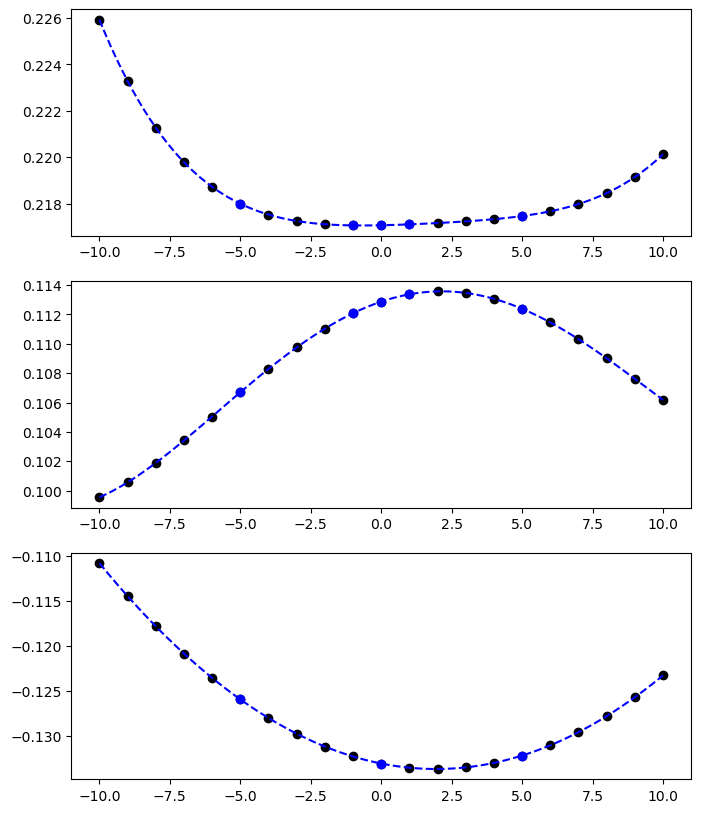

In [61]:
mcfm_c6_pts = np.linspace(-10,10,21)
mcfm_msq_c6_sbi = [f'msq_sbi_c6_{i}' for i in range(1,22)]
mcfm_msq_c6_sig = [f'msq_sig_c6_{i}' for i in range(1,22)]
mcfm_msq_c6_int = [f'msq_int_c6_{i}' for i in range(1,22)]

random_event = sample.events.iloc[random_event_index]

# all MCFM-generated points
mcfm_wt_c6_sbi = np.zeros(21)
mcfm_wt_c6_sig = np.zeros(21)
mcfm_wt_c6_int = np.zeros(21)
for i in range(21):
  mcfm_wt_c6_sbi[i] = random_event['wt'] * random_event[f'msq_sbi_c6_{i+1}'] / random_event['msq_sbi_sm']
  mcfm_wt_c6_sig[i] = random_event['wt'] * random_event[f'msq_sig_c6_{i+1}'] / random_event['msq_sbi_sm'] 
  mcfm_wt_c6_int[i] = random_event['wt'] * random_event[f'msq_int_c6_{i+1}'] / random_event['msq_sbi_sm'] 

# subset of MCFM-generated points for modifier
c6in_sbi = np.zeros(5)
mcfm_msq_inputs_sbi = ['msq_sbi_c6_6', 'msq_sbi_c6_10', 'msq_sbi_c6_11', 'msq_sbi_c6_12', 'msq_sbi_c6_16']
c6in_sig = np.zeros(5)
mcfm_msq_inputs_sig = ['msq_sig_c6_6', 'msq_sig_c6_10', 'msq_sig_c6_11', 'msq_sig_c6_12', 'msq_sig_c6_16']
c6in_int = np.zeros(3)
mcfm_msq_inputs_int = ['msq_int_c6_6', 'msq_int_c6_11', 'msq_int_c6_16']
for i in range(5):
  c6in_sbi[i] = random_event['wt'] * random_event[mcfm_msq_inputs_sbi[i]] / random_event['msq_sbi_sm']
  c6in_sig[i] = random_event['wt'] * random_event[mcfm_msq_inputs_sig[i]] / random_event['msq_sbi_sm'] 
for i in range(3):
  c6in_int[i] = random_event['wt'] * random_event[mcfm_msq_inputs_int[i]] / random_event['msq_sbi_sm'] 


fig, (ax_sbi ,ax_sig, ax_int) = plt.subplots(3, 1, figsize=(8, 10))

ax_sbi.scatter([-5,-1,0,1,5], c6in_sbi, marker='o', color='blue', label='MCFM (input)', zorder=10)
ax_sbi.scatter(mcfm_c6_pts, mcfm_wt_c6_sbi, marker='o', color='black', label='MCFM (all)')
ax_sbi.plot(c6_values, c6wt_sbi, color='blue', linestyle='--', label='morphed')

ax_sig.scatter([-5,-1,0,1,5], c6in_sig, marker='o', color='blue', label='MCFM (input)', zorder=10)
ax_sig.scatter(mcfm_c6_pts, mcfm_wt_c6_sig, marker='o', color='black', label='SIG')
ax_sig.plot(c6_values, c6wt_sig, color='blue', linestyle='--', label='morphed')

ax_int.scatter([-5,0,5], c6in_int, marker='o', color='blue', label='MCFM (input)', zorder=10)
ax_int.scatter(mcfm_c6_pts, mcfm_wt_c6_int, marker='o', color='black', label='INT')
ax_int.plot(c6_values, c6wt_int, color='blue', linestyle='--', label='morphed')

## $(c_6, c_H)$ modification

The modifier class also accepts a universal Higgs field scaling by $c_H$.

In [63]:
cH_values = np.array([-0.1, -0.01, 0.0, 0.01, 0.1])

wt_c6_cH = c6mod_sbi.modify(sample, c6_values, cH_values)[random_event_index]

print(wt_c6_cH[51])

[4.34136197e-01 2.60484023e-01 2.17070980e-01 1.73657936e-01
 5.76257325e-06]
